# Importar Bibliotecas Necessárias

In [125]:
# Importar as bibliotecas

# -*- coding: utf-8 -*-

import numpy as np
from timeit import default_timer as timer
import random
import serial
import serial.tools.list_ports
import os
from math import sqrt
import argparse
import matplotlib as plt
import pandas as pd
import tensorflow as tf

from datetime import datetime
from scipy.fft import fft

# https://www.linkedin.com/pulse/lendo-arquivos-csv-com-pandas-rog%C3%A9rio-guimar%C3%A3es-de-campos-j%C3%BAnior/
# https://stackabuse.com/python-list-files-in-a-directory/

In [126]:
# Carregar dados MPL para modelo RNN

# Definição do paciente e os diretórios
nome = "Anderson_CH1_MSE"

# Caminho dos dados
filename = f"Dataset\\{nome}\\dados_classificacao.csv"
filename_limiar = f"Dataset\\{nome}\\limiar.txt"
filename_movimentos = f"Dataset\\{nome}\\movimentos_classificacao.csv"


# Extração de características do sinal (Input Layer)

In [127]:
# Transforma de str para float

def str2float(Part):
    for i in range(0, len(Part)):
        Part[i] = Part[i].split(';')
        for j in range(0, len(Part[i])):
            Part[i][j] = float(Part[i][j].replace(',', '.'))

    return Part

In [128]:
# Calcula: RMS 

def f_rms(dado, segments):
    Vrms = []
    
    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    for s in range(0, segments): 
        soma = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2):
            soma = soma + (dado[sample] ** 2) 

        Vrms.append(sqrt(soma/segment))
        aux = aux_2 - 1

    return Vrms

In [129]:
# Detecta o impulso baseado no ruído em repouso do músculo
def delta_dirac(data_full, filename_limiar, N, janela):
    # Valor obtido empiricamente utilizando o repouso
    with open(filename_limiar, 'r') as l:
        limiar = l.read()
    
    limiar = float(limiar)
    segments = 1
    
    # Compara se algum dos valores é maior que o limiar, caso sim efetua o RMS
    # dos próximos 40 pontos (baseado em Rodrigo Ortolan)
    # Se o RMS desses 40 pontos for maior que o limiar considera este o inicio da contração 
    # E retorna 400 pontos referentes aos 200ms do começo do sinal
    for row in range(0, len(data_full)):
        if data_full[row] > limiar:
            rms = f_rms(data_full[row:(row + janela)], segments)
            if (rms[0]) > limiar:
                #print (row)
                data_part = data_full[row:(row + N)]
                
                return data_part

In [130]:
# Calcula: Comprimento do traço do sinal

def waveform_length(dado, segments):
    # segment[sample] = Xk
    # segment[sample-1] = Xk-1
    
    l0_list = []
    
    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    for s in range(0, segments):
        l0 = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2):
            l0 = l0 + abs(dado[sample] - dado[sample-1])
        
        l0_list.append(l0)
        aux = aux_2
        
    # print (f"l0: {l0_list}")
    return l0_list

In [131]:
# Calcula: Média do Valor Absoluta

# Recebe uma amostra com 400 pontos e faz a media absoluta baseada na quantidade de segmentos
def mean_absolute_value(dado, segments):
    MAV = []
    
    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    
    for s in range(0, segments): 
        soma = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2):
                soma = soma + abs(float(dado[sample]))
    
        MAV.append(soma/segment)
        aux = aux_2 - 1
        
    # print (f"MAV: {MAV}")
    return MAV

In [132]:
# Calcula: Zero Crossing (ZC)

def zero_crossing(dado, segments): 
    ZC = []

    segment = int(len(dado)/segments)
    aux = 0
    aux_2 = segment
    
    # X0 = Xk
    # X1 = Xk+1
    
    for s in range(0, segments): 
        count = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2-1):
            X0 = dado[sample]
            X1 = dado[sample + 1]
            # abs(Xk - Xk-1) >= 10mV
            # limiar (threshhold) = 10mV. Noise INA332 = 7uVp-p. Para ter contagem de ZC falsos
            if (((X0 > 0 and X1 < 0) or (X0 < 0 and X1 > 0)) and (abs(X0 - X1) >= 0.01)):
                count += 1
                # print (f"Diferença para ZC: {abs(X0 - X1)}")
        
        ZC.append(count)
        aux = aux_2 - 1
    
    # print (f"ZC: {ZC}")    
    return ZC
    
    

In [133]:
# Calcula: A mudança de sinais

def slope_sign_changes(dado, segments):
    SSC = []
    
    # X0 = Xk-1
    # X1 = Xk
    # X2 = Xk+1
    
    segment = int(len(dado)/segments)
    aux = 1
    aux_2 = segment
    
    for s in range(0, segments): 
        count = 0
        aux_2 = segment * (s+1)
        for sample in range(aux, aux_2 - 1):
            X0 = dado[sample - 1]
            X1 = dado[sample]
            X2 = dado[sample + 1]
            if (((X1 > X0  and X1 > X2) or (X1 < X0 and X1 < X2)) and ((abs(X1 - X2) >= 0.01) or (abs(X1 - X0) >= 0.01))):
                count += 1
                
        SSC.append(count)
        aux = aux_2 - 1
    
    # print (f"SSC: {SSC}")
    return SSC

In [134]:
# Calcula: Ângulo de inclinação da média do valor absoluto

def mean_absolute_value_slope(dado, segments):
    # MAV = Xi
    # MAV1 = Xi+1
    
    MAVSLP = []
    MAV = mean_absolute_value(dado, segments)
    
    for s in range(0, (segments-1)):
        MAVSLP.append(abs(MAV[s+1] - MAV[s])) 
    
    MAVSLP.append(0.0)
    
    # print (f"MAVSLP{MAVSLP}")        
    return MAVSLP

In [135]:
lines = []
y = []
qty_lines = 80

with open(filename, 'r') as f:
    for i in range(0, qty_lines):
        lines.append(f.readline())
        
with open(filename_movimentos, 'r') as f:
    for i in range(0, qty_lines):
        read_data = f.readline()
        read_data = list(read_data.split(';'))
        for j in range(0, len(read_data)):
            read_data[j] = int(read_data[j])
        y.append(read_data)

lines = str2float(lines)

#display(lines[0])

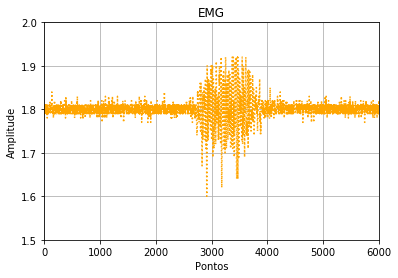

In [136]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(range(len(lines[0])))

plt.plot( x, lines[15], 'k:', color='orange') # linha pontilha orange

plt.axis([0, 6000, 1.5, 2])
plt.title("EMG")

plt.grid(True)
plt.xlabel("Pontos")
plt.ylabel("Amplitude")
plt.show()

In [137]:
# Definição de parâmetros para obtenção dos 200ms
N = 400
janela = 10

Part = []
i = 0

for line in lines:
    #print (i+1)
    det = delta_dirac(line, filename_limiar, N, janela) 
    if (det != None):
        Part.append(det)
    else:
        y[i] = -1
    i += 1

# display(len(y))

while (-1 in y):
    y.remove(-1)

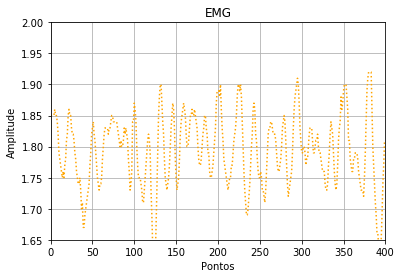

In [138]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(range(len(Part[0])))

plt.plot( x, Part[15], 'k:', color='orange') # linha pontilha orange

plt.axis([0, 400, 1.65, 2])
plt.title("EMG")

plt.grid(True)
plt.xlabel("Pontos")
plt.ylabel("Amplitude")
plt.show()

In [139]:
# Normalizar os dados
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
Part_normalize = scaler.fit_transform(Part)

In [199]:
# Extrai os parâmetros necessários de uma segunda forma

# Adendo: Basicamente será testada a rede de Hudgins, mas diferente do artigo original será usada uma rede melhorada da RNN,
# que neste caso é a LSTM

# Criação do Array para LSTM
segments = 2 # Assim como Hudgins é possível modificar a quantidade de segmentos e ver o quanto melhora ou piora a acurácia obtida

X = np.ones((len(Part_normalize), segments, 6))

# Extrair características
for idx,p in enumerate(Part_normalize):
    X[idx,:,0] = mean_absolute_value(p, segments)
    X[idx,:,1] = waveform_length(p, segments)
    X[idx,:,2] = f_rms(p, segments)
    X[idx,:,3] = mean_absolute_value_slope(p, segments)
    X[idx,:,4] = zero_crossing(p, segments)
    X[idx,:,5] = slope_sign_changes(p, segments)

# Reshape deve ser: (quantidade de amostras, 3)
y = np.array(y)

display(X[0,:,:])
display(X[2,:,:])
display(X.shape)

array([[ 0.27298803, 23.26682277,  0.33369929,  0.10639152, 16.        ,
        71.        ],
       [ 0.37937955, 28.66553356,  0.46005911,  0.        , 19.        ,
        58.        ]])

array([[2.78665323e-01, 2.39705380e+01, 3.57953806e-01, 4.39620901e-02,
        2.20000000e+01, 8.10000000e+01],
       [3.22627413e-01, 2.70116307e+01, 3.98610212e-01, 0.00000000e+00,
        2.30000000e+01, 5.30000000e+01]])

(80, 2, 6)

In [200]:
# Importando biblioteca de treino e teste
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

display(X_train)
display(y_train)
display(X_test)
display(y_test)

array([[[2.76175406e-01, 2.76175966e+01, 3.36568286e-01, 4.87471086e-02,
         1.70000000e+01, 8.50000000e+01],
        [2.27428298e-01, 2.33299406e+01, 2.95991681e-01, 0.00000000e+00,
         2.70000000e+01, 1.00000000e+02]],

       [[4.17799326e-01, 2.60569212e+01, 5.06380913e-01, 1.05647987e-02,
         1.50000000e+01, 7.50000000e+01],
        [4.28364124e-01, 2.69127548e+01, 5.27319184e-01, 0.00000000e+00,
         1.90000000e+01, 7.10000000e+01]],

       [[3.20675154e-01, 2.62176068e+01, 3.90356135e-01, 3.33697574e-02,
         1.50000000e+01, 8.20000000e+01],
        [2.87305397e-01, 2.49568606e+01, 3.89079736e-01, 0.00000000e+00,
         2.30000000e+01, 9.70000000e+01]],

       [[4.08878492e-01, 2.86804580e+01, 4.98366242e-01, 1.11214942e-01,
         1.80000000e+01, 5.90000000e+01],
        [2.97663549e-01, 2.66083756e+01, 3.82270999e-01, 0.00000000e+00,
         2.40000000e+01, 8.20000000e+01]],

       [[2.90206975e-01, 2.59751844e+01, 3.57498850e-01, 6.74095981e-02,

array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0]])

array([[[3.23879122e-01, 2.71923473e+01, 4.03060501e-01, 3.37524515e-02,
         2.30000000e+01, 8.30000000e+01],
        [3.57631574e-01, 2.54173665e+01, 4.47552087e-01, 0.00000000e+00,
         1.80000000e+01, 7.70000000e+01]],

       [[2.70124102e-01, 2.09286857e+01, 3.36583158e-01, 3.55064395e-03,
         1.70000000e+01, 8.60000000e+01],
        [2.73674746e-01, 2.28650374e+01, 3.58619888e-01, 0.00000000e+00,
         1.70000000e+01, 5.90000000e+01]],

       [[2.72749863e-01, 2.60481779e+01, 3.44927634e-01, 6.82030439e-03,
         2.10000000e+01, 7.50000000e+01],
        [2.79570167e-01, 2.60679769e+01, 3.59599670e-01, 0.00000000e+00,
         2.00000000e+01, 6.40000000e+01]],

       [[2.86011028e-01, 2.45896779e+01, 3.45881238e-01, 9.87500658e-04,
         1.50000000e+01, 8.80000000e+01],
        [2.85023527e-01, 2.10213198e+01, 3.49336632e-01, 0.00000000e+00,
         1.80000000e+01, 7.90000000e+01]],

       [[3.49331680e-01, 2.91571730e+01, 4.44369690e-01, 3.39532479e-02,

array([[1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1]])

# Rede LSTM

Train on 64 samples, validate on 16 samples
Epoch 1/1000
64/64 [==============================] - 4s 68ms/sample - loss: 0.6823 - acc: 0.6250 - val_loss: 0.6723 - val_acc: 0.5625
Epoch 2/1000
64/64 [==============================] - 0s 211us/sample - loss: 0.6800 - acc: 0.6094 - val_loss: 0.6698 - val_acc: 0.6250
Epoch 3/1000
64/64 [==============================] - 0s 241us/sample - loss: 0.6779 - acc: 0.6094 - val_loss: 0.6671 - val_acc: 0.7500
Epoch 4/1000
64/64 [==============================] - 0s 263us/sample - loss: 0.6759 - acc: 0.5938 - val_loss: 0.6643 - val_acc: 0.7500
Epoch 5/1000
64/64 [==============================] - 0s 174us/sample - loss: 0.6740 - acc: 0.5781 - val_loss: 0.6617 - val_acc: 0.7500
Epoch 6/1000
64/64 [==============================] - 0s 300us/sample - loss: 0.6723 - acc: 0.5781 - val_loss: 0.6593 - val_acc: 0.7500
Epoch 7/1000
64/64 [==============================] - 0s 267us/sample - loss: 0.6708 - acc: 0.5781 - val_loss: 0.6573 - val_acc: 0.7500
Epoch

Epoch 61/1000
64/64 [==============================] - 0s 185us/sample - loss: 0.6219 - acc: 0.6719 - val_loss: 0.5758 - val_acc: 0.8125
Epoch 62/1000
64/64 [==============================] - 0s 190us/sample - loss: 0.6213 - acc: 0.6719 - val_loss: 0.5741 - val_acc: 0.8125
Epoch 63/1000
64/64 [==============================] - 0s 208us/sample - loss: 0.6208 - acc: 0.6719 - val_loss: 0.5724 - val_acc: 0.8125
Epoch 64/1000
64/64 [==============================] - 0s 216us/sample - loss: 0.6203 - acc: 0.6719 - val_loss: 0.5711 - val_acc: 0.8125
Epoch 65/1000
64/64 [==============================] - 0s 194us/sample - loss: 0.6198 - acc: 0.6719 - val_loss: 0.5704 - val_acc: 0.8125
Epoch 66/1000
64/64 [==============================] - 0s 178us/sample - loss: 0.6192 - acc: 0.6719 - val_loss: 0.5701 - val_acc: 0.8125
Epoch 67/1000
64/64 [==============================] - 0s 291us/sample - loss: 0.6187 - acc: 0.6719 - val_loss: 0.5698 - val_acc: 0.8125
Epoch 68/1000
64/64 [====================

Epoch 121/1000
64/64 [==============================] - 0s 169us/sample - loss: 0.5828 - acc: 0.7031 - val_loss: 0.5636 - val_acc: 0.8125
Epoch 122/1000
64/64 [==============================] - 0s 286us/sample - loss: 0.5819 - acc: 0.7188 - val_loss: 0.5638 - val_acc: 0.8125
Epoch 123/1000
64/64 [==============================] - 0s 269us/sample - loss: 0.5811 - acc: 0.7188 - val_loss: 0.5641 - val_acc: 0.8125
Epoch 124/1000
64/64 [==============================] - 0s 181us/sample - loss: 0.5803 - acc: 0.7188 - val_loss: 0.5642 - val_acc: 0.8125
Epoch 125/1000
64/64 [==============================] - 0s 168us/sample - loss: 0.5794 - acc: 0.7188 - val_loss: 0.5643 - val_acc: 0.8125
Epoch 126/1000
64/64 [==============================] - 0s 208us/sample - loss: 0.5786 - acc: 0.7188 - val_loss: 0.5643 - val_acc: 0.8125
Epoch 127/1000
64/64 [==============================] - 0s 292us/sample - loss: 0.5778 - acc: 0.7031 - val_loss: 0.5643 - val_acc: 0.8125
Epoch 128/1000
64/64 [============

Epoch 181/1000
64/64 [==============================] - 0s 316us/sample - loss: 0.5360 - acc: 0.7188 - val_loss: 0.5621 - val_acc: 0.7500
Epoch 182/1000
64/64 [==============================] - 0s 297us/sample - loss: 0.5353 - acc: 0.7188 - val_loss: 0.5617 - val_acc: 0.7500
Epoch 183/1000
64/64 [==============================] - 0s 229us/sample - loss: 0.5346 - acc: 0.7188 - val_loss: 0.5613 - val_acc: 0.7500
Epoch 184/1000
64/64 [==============================] - 0s 286us/sample - loss: 0.5339 - acc: 0.7344 - val_loss: 0.5609 - val_acc: 0.7500
Epoch 185/1000
64/64 [==============================] - 0s 281us/sample - loss: 0.5332 - acc: 0.7344 - val_loss: 0.5611 - val_acc: 0.7500
Epoch 186/1000
64/64 [==============================] - 0s 191us/sample - loss: 0.5325 - acc: 0.7344 - val_loss: 0.5618 - val_acc: 0.7500
Epoch 187/1000
64/64 [==============================] - 0s 251us/sample - loss: 0.5318 - acc: 0.7344 - val_loss: 0.5621 - val_acc: 0.7500
Epoch 188/1000
64/64 [============

Epoch 241/1000
64/64 [==============================] - 0s 268us/sample - loss: 0.4957 - acc: 0.7656 - val_loss: 0.5585 - val_acc: 0.7500
Epoch 242/1000
64/64 [==============================] - 0s 209us/sample - loss: 0.4951 - acc: 0.7656 - val_loss: 0.5588 - val_acc: 0.7500
Epoch 243/1000
64/64 [==============================] - 0s 151us/sample - loss: 0.4945 - acc: 0.7656 - val_loss: 0.5585 - val_acc: 0.7500
Epoch 244/1000
64/64 [==============================] - 0s 168us/sample - loss: 0.4938 - acc: 0.7656 - val_loss: 0.5579 - val_acc: 0.7500
Epoch 245/1000
64/64 [==============================] - 0s 191us/sample - loss: 0.4932 - acc: 0.7656 - val_loss: 0.5580 - val_acc: 0.7500
Epoch 246/1000
64/64 [==============================] - 0s 244us/sample - loss: 0.4925 - acc: 0.7656 - val_loss: 0.5578 - val_acc: 0.7500
Epoch 247/1000
64/64 [==============================] - 0s 253us/sample - loss: 0.4918 - acc: 0.7656 - val_loss: 0.5577 - val_acc: 0.7500
Epoch 248/1000
64/64 [============

Epoch 301/1000
64/64 [==============================] - 0s 199us/sample - loss: 0.4571 - acc: 0.7812 - val_loss: 0.5581 - val_acc: 0.7500
Epoch 302/1000
64/64 [==============================] - 0s 152us/sample - loss: 0.4565 - acc: 0.7812 - val_loss: 0.5574 - val_acc: 0.7500
Epoch 303/1000
64/64 [==============================] - 0s 234us/sample - loss: 0.4559 - acc: 0.7812 - val_loss: 0.5573 - val_acc: 0.7500
Epoch 304/1000
64/64 [==============================] - 0s 267us/sample - loss: 0.4554 - acc: 0.7812 - val_loss: 0.5569 - val_acc: 0.7500
Epoch 305/1000
64/64 [==============================] - 0s 172us/sample - loss: 0.4548 - acc: 0.7812 - val_loss: 0.5568 - val_acc: 0.7500
Epoch 306/1000
64/64 [==============================] - 0s 244us/sample - loss: 0.4542 - acc: 0.7812 - val_loss: 0.5568 - val_acc: 0.7500
Epoch 307/1000
64/64 [==============================] - 0s 209us/sample - loss: 0.4536 - acc: 0.7812 - val_loss: 0.5576 - val_acc: 0.7500
Epoch 308/1000
64/64 [============

Epoch 361/1000
64/64 [==============================] - 0s 248us/sample - loss: 0.4241 - acc: 0.7969 - val_loss: 0.5531 - val_acc: 0.7500
Epoch 362/1000
64/64 [==============================] - 0s 187us/sample - loss: 0.4236 - acc: 0.7969 - val_loss: 0.5530 - val_acc: 0.7500
Epoch 363/1000
64/64 [==============================] - 0s 192us/sample - loss: 0.4231 - acc: 0.7969 - val_loss: 0.5531 - val_acc: 0.7500
Epoch 364/1000
64/64 [==============================] - 0s 279us/sample - loss: 0.4226 - acc: 0.7969 - val_loss: 0.5530 - val_acc: 0.7500
Epoch 365/1000
64/64 [==============================] - 0s 252us/sample - loss: 0.4221 - acc: 0.7969 - val_loss: 0.5530 - val_acc: 0.7500
Epoch 366/1000
64/64 [==============================] - 0s 277us/sample - loss: 0.4216 - acc: 0.7969 - val_loss: 0.5530 - val_acc: 0.7500
Epoch 367/1000
64/64 [==============================] - 0s 258us/sample - loss: 0.4211 - acc: 0.7969 - val_loss: 0.5531 - val_acc: 0.7500
Epoch 368/1000
64/64 [============

Epoch 421/1000
64/64 [==============================] - 0s 189us/sample - loss: 0.3975 - acc: 0.8125 - val_loss: 0.5543 - val_acc: 0.7500
Epoch 422/1000
64/64 [==============================] - 0s 195us/sample - loss: 0.3971 - acc: 0.8125 - val_loss: 0.5547 - val_acc: 0.7500
Epoch 423/1000
64/64 [==============================] - 0s 209us/sample - loss: 0.3967 - acc: 0.8125 - val_loss: 0.5549 - val_acc: 0.7500
Epoch 424/1000
64/64 [==============================] - 0s 226us/sample - loss: 0.3964 - acc: 0.8125 - val_loss: 0.5552 - val_acc: 0.7500
Epoch 425/1000
64/64 [==============================] - 0s 213us/sample - loss: 0.3959 - acc: 0.8125 - val_loss: 0.5554 - val_acc: 0.7500
Epoch 426/1000
64/64 [==============================] - 0s 309us/sample - loss: 0.3956 - acc: 0.8281 - val_loss: 0.5550 - val_acc: 0.7500
Epoch 427/1000
64/64 [==============================] - 0s 281us/sample - loss: 0.3952 - acc: 0.8125 - val_loss: 0.5542 - val_acc: 0.7500
Epoch 428/1000
64/64 [============

Epoch 481/1000
64/64 [==============================] - 0s 269us/sample - loss: 0.3754 - acc: 0.8594 - val_loss: 0.5580 - val_acc: 0.7500
Epoch 482/1000
64/64 [==============================] - 0s 346us/sample - loss: 0.3750 - acc: 0.8594 - val_loss: 0.5578 - val_acc: 0.8125
Epoch 483/1000
64/64 [==============================] - 0s 205us/sample - loss: 0.3747 - acc: 0.8594 - val_loss: 0.5579 - val_acc: 0.8125
Epoch 484/1000
64/64 [==============================] - 0s 192us/sample - loss: 0.3743 - acc: 0.8594 - val_loss: 0.5586 - val_acc: 0.7500
Epoch 485/1000
64/64 [==============================] - 0s 368us/sample - loss: 0.3740 - acc: 0.8594 - val_loss: 0.5592 - val_acc: 0.7500
Epoch 486/1000
64/64 [==============================] - 0s 312us/sample - loss: 0.3737 - acc: 0.8594 - val_loss: 0.5590 - val_acc: 0.7500
Epoch 487/1000
64/64 [==============================] - 0s 291us/sample - loss: 0.3734 - acc: 0.8594 - val_loss: 0.5587 - val_acc: 0.7500
Epoch 488/1000
64/64 [============

Epoch 541/1000
64/64 [==============================] - 0s 183us/sample - loss: 0.3568 - acc: 0.8594 - val_loss: 0.5616 - val_acc: 0.8125
Epoch 542/1000
64/64 [==============================] - 0s 145us/sample - loss: 0.3565 - acc: 0.8594 - val_loss: 0.5616 - val_acc: 0.8750
Epoch 543/1000
64/64 [==============================] - 0s 172us/sample - loss: 0.3562 - acc: 0.8594 - val_loss: 0.5611 - val_acc: 0.8750
Epoch 544/1000
64/64 [==============================] - 0s 245us/sample - loss: 0.3560 - acc: 0.8594 - val_loss: 0.5606 - val_acc: 0.8750
Epoch 545/1000
64/64 [==============================] - 0s 266us/sample - loss: 0.3556 - acc: 0.8594 - val_loss: 0.5603 - val_acc: 0.8125
Epoch 546/1000
64/64 [==============================] - 0s 282us/sample - loss: 0.3553 - acc: 0.8594 - val_loss: 0.5604 - val_acc: 0.8750
Epoch 547/1000
64/64 [==============================] - 0s 249us/sample - loss: 0.3551 - acc: 0.8594 - val_loss: 0.5608 - val_acc: 0.8750
Epoch 548/1000
64/64 [============

Epoch 601/1000
64/64 [==============================] - 0s 202us/sample - loss: 0.3407 - acc: 0.8906 - val_loss: 0.5600 - val_acc: 0.8125
Epoch 602/1000
64/64 [==============================] - 0s 202us/sample - loss: 0.3405 - acc: 0.8906 - val_loss: 0.5602 - val_acc: 0.8125
Epoch 603/1000
64/64 [==============================] - 0s 167us/sample - loss: 0.3402 - acc: 0.8906 - val_loss: 0.5619 - val_acc: 0.8125
Epoch 604/1000
64/64 [==============================] - 0s 205us/sample - loss: 0.3400 - acc: 0.8906 - val_loss: 0.5622 - val_acc: 0.8125
Epoch 605/1000
64/64 [==============================] - 0s 282us/sample - loss: 0.3397 - acc: 0.8906 - val_loss: 0.5616 - val_acc: 0.8125
Epoch 606/1000
64/64 [==============================] - 0s 262us/sample - loss: 0.3394 - acc: 0.8906 - val_loss: 0.5618 - val_acc: 0.8125
Epoch 607/1000
64/64 [==============================] - 0s 255us/sample - loss: 0.3392 - acc: 0.8906 - val_loss: 0.5626 - val_acc: 0.8125
Epoch 608/1000
64/64 [============

Epoch 661/1000
64/64 [==============================] - 0s 155us/sample - loss: 0.3265 - acc: 0.8906 - val_loss: 0.5664 - val_acc: 0.8125
Epoch 662/1000
64/64 [==============================] - 0s 173us/sample - loss: 0.3263 - acc: 0.8906 - val_loss: 0.5664 - val_acc: 0.8125
Epoch 663/1000
64/64 [==============================] - 0s 261us/sample - loss: 0.3261 - acc: 0.8906 - val_loss: 0.5663 - val_acc: 0.8125
Epoch 664/1000
64/64 [==============================] - 0s 210us/sample - loss: 0.3259 - acc: 0.8906 - val_loss: 0.5652 - val_acc: 0.8125
Epoch 665/1000
64/64 [==============================] - 0s 254us/sample - loss: 0.3256 - acc: 0.8906 - val_loss: 0.5648 - val_acc: 0.8125
Epoch 666/1000
64/64 [==============================] - 0s 302us/sample - loss: 0.3254 - acc: 0.8906 - val_loss: 0.5653 - val_acc: 0.8125
Epoch 667/1000
64/64 [==============================] - 0s 308us/sample - loss: 0.3252 - acc: 0.8906 - val_loss: 0.5664 - val_acc: 0.8125
Epoch 668/1000
64/64 [============

Epoch 721/1000
64/64 [==============================] - 0s 182us/sample - loss: 0.3132 - acc: 0.9062 - val_loss: 0.5734 - val_acc: 0.6875
Epoch 722/1000
64/64 [==============================] - 0s 216us/sample - loss: 0.3129 - acc: 0.9062 - val_loss: 0.5746 - val_acc: 0.6875
Epoch 723/1000
64/64 [==============================] - 0s 197us/sample - loss: 0.3126 - acc: 0.9062 - val_loss: 0.5757 - val_acc: 0.6875
Epoch 724/1000
64/64 [==============================] - 0s 278us/sample - loss: 0.3125 - acc: 0.9062 - val_loss: 0.5751 - val_acc: 0.6875
Epoch 725/1000
64/64 [==============================] - 0s 217us/sample - loss: 0.3122 - acc: 0.8906 - val_loss: 0.5739 - val_acc: 0.6875
Epoch 726/1000
64/64 [==============================] - 0s 235us/sample - loss: 0.3119 - acc: 0.9062 - val_loss: 0.5745 - val_acc: 0.6875
Epoch 727/1000
64/64 [==============================] - 0s 269us/sample - loss: 0.3118 - acc: 0.9062 - val_loss: 0.5758 - val_acc: 0.6875
Epoch 728/1000
64/64 [============

Epoch 781/1000
64/64 [==============================] - 0s 108us/sample - loss: 0.2999 - acc: 0.9219 - val_loss: 0.5888 - val_acc: 0.6875
Epoch 782/1000
64/64 [==============================] - 0s 158us/sample - loss: 0.2996 - acc: 0.9219 - val_loss: 0.5899 - val_acc: 0.6875
Epoch 783/1000
64/64 [==============================] - 0s 192us/sample - loss: 0.2994 - acc: 0.9219 - val_loss: 0.5904 - val_acc: 0.6875
Epoch 784/1000
64/64 [==============================] - 0s 307us/sample - loss: 0.2992 - acc: 0.9219 - val_loss: 0.5907 - val_acc: 0.6875
Epoch 785/1000
64/64 [==============================] - 0s 306us/sample - loss: 0.2990 - acc: 0.9219 - val_loss: 0.5923 - val_acc: 0.6875
Epoch 786/1000
64/64 [==============================] - 0s 267us/sample - loss: 0.2988 - acc: 0.9062 - val_loss: 0.5931 - val_acc: 0.6875
Epoch 787/1000
64/64 [==============================] - 0s 264us/sample - loss: 0.2986 - acc: 0.9219 - val_loss: 0.5923 - val_acc: 0.6875
Epoch 788/1000
64/64 [============

Epoch 841/1000
64/64 [==============================] - 0s 250us/sample - loss: 0.2876 - acc: 0.9062 - val_loss: 0.6006 - val_acc: 0.6875
Epoch 842/1000
64/64 [==============================] - 0s 216us/sample - loss: 0.2873 - acc: 0.9062 - val_loss: 0.6012 - val_acc: 0.6875
Epoch 843/1000
64/64 [==============================] - 0s 203us/sample - loss: 0.2872 - acc: 0.9062 - val_loss: 0.5999 - val_acc: 0.6875
Epoch 844/1000
64/64 [==============================] - 0s 253us/sample - loss: 0.2870 - acc: 0.9062 - val_loss: 0.6013 - val_acc: 0.6875
Epoch 845/1000
64/64 [==============================] - 0s 270us/sample - loss: 0.2868 - acc: 0.9062 - val_loss: 0.6023 - val_acc: 0.6875
Epoch 846/1000
64/64 [==============================] - 0s 291us/sample - loss: 0.2865 - acc: 0.9062 - val_loss: 0.6027 - val_acc: 0.6875
Epoch 847/1000
64/64 [==============================] - 0s 223us/sample - loss: 0.2864 - acc: 0.9062 - val_loss: 0.6026 - val_acc: 0.6875
Epoch 848/1000
64/64 [============

Epoch 901/1000
64/64 [==============================] - 0s 180us/sample - loss: 0.2764 - acc: 0.9062 - val_loss: 0.6122 - val_acc: 0.6875
Epoch 902/1000
64/64 [==============================] - 0s 277us/sample - loss: 0.2763 - acc: 0.9062 - val_loss: 0.6114 - val_acc: 0.6875
Epoch 903/1000
64/64 [==============================] - 0s 156us/sample - loss: 0.2760 - acc: 0.9062 - val_loss: 0.6129 - val_acc: 0.6875
Epoch 904/1000
64/64 [==============================] - 0s 171us/sample - loss: 0.2759 - acc: 0.9062 - val_loss: 0.6133 - val_acc: 0.6875
Epoch 905/1000
64/64 [==============================] - 0s 223us/sample - loss: 0.2758 - acc: 0.9062 - val_loss: 0.6120 - val_acc: 0.6875
Epoch 906/1000
64/64 [==============================] - 0s 191us/sample - loss: 0.2755 - acc: 0.9062 - val_loss: 0.6125 - val_acc: 0.6875
Epoch 907/1000
64/64 [==============================] - 0s 228us/sample - loss: 0.2754 - acc: 0.9062 - val_loss: 0.6135 - val_acc: 0.6875
Epoch 908/1000
64/64 [============

Epoch 961/1000
64/64 [==============================] - 0s 250us/sample - loss: 0.2665 - acc: 0.9062 - val_loss: 0.6221 - val_acc: 0.6875
Epoch 962/1000
64/64 [==============================] - 0s 199us/sample - loss: 0.2664 - acc: 0.9062 - val_loss: 0.6223 - val_acc: 0.6875
Epoch 963/1000
64/64 [==============================] - 0s 254us/sample - loss: 0.2662 - acc: 0.8906 - val_loss: 0.6242 - val_acc: 0.6875
Epoch 964/1000
64/64 [==============================] - 0s 224us/sample - loss: 0.2661 - acc: 0.8906 - val_loss: 0.6247 - val_acc: 0.6875
Epoch 965/1000
64/64 [==============================] - 0s 274us/sample - loss: 0.2659 - acc: 0.8906 - val_loss: 0.6245 - val_acc: 0.6875
Epoch 966/1000
64/64 [==============================] - 0s 127us/sample - loss: 0.2659 - acc: 0.8906 - val_loss: 0.6247 - val_acc: 0.6875
Epoch 967/1000
64/64 [==============================] - 0s 211us/sample - loss: 0.2657 - acc: 0.8906 - val_loss: 0.6265 - val_acc: 0.6875
Epoch 968/1000
64/64 [============

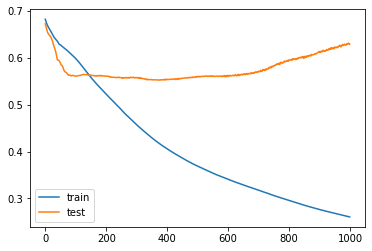

In [205]:
# Criar a rede LSTM
# Importar bibliotecas para criação do modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras import Input

# design network
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
# Definindo método de acurácia e perda
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test), shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Rede GRU

Train on 64 samples, validate on 16 samples
Epoch 1/1000
64/64 - 3s - loss: 0.7053 - acc: 0.5000 - val_loss: 0.7009 - val_acc: 0.5000
Epoch 2/1000
64/64 - 0s - loss: 0.7017 - acc: 0.5000 - val_loss: 0.6971 - val_acc: 0.5000
Epoch 3/1000
64/64 - 0s - loss: 0.6971 - acc: 0.5000 - val_loss: 0.6942 - val_acc: 0.5000
Epoch 4/1000
64/64 - 0s - loss: 0.6956 - acc: 0.5000 - val_loss: 0.6910 - val_acc: 0.5000
Epoch 5/1000
64/64 - 0s - loss: 0.6919 - acc: 0.5000 - val_loss: 0.6880 - val_acc: 0.5000
Epoch 6/1000
64/64 - 0s - loss: 0.6900 - acc: 0.5000 - val_loss: 0.6849 - val_acc: 0.5000
Epoch 7/1000
64/64 - 0s - loss: 0.6876 - acc: 0.5000 - val_loss: 0.6817 - val_acc: 0.5000
Epoch 8/1000
64/64 - 0s - loss: 0.6853 - acc: 0.5000 - val_loss: 0.6785 - val_acc: 0.5000
Epoch 9/1000
64/64 - 0s - loss: 0.6841 - acc: 0.5625 - val_loss: 0.6750 - val_acc: 0.6250
Epoch 10/1000
64/64 - 0s - loss: 0.6814 - acc: 0.6250 - val_loss: 0.6707 - val_acc: 0.8750
Epoch 11/1000
64/64 - 0s - loss: 0.6810 - acc: 0.5625 -

Epoch 91/1000
64/64 - 0s - loss: 0.6005 - acc: 0.7188 - val_loss: 0.5945 - val_acc: 0.8750
Epoch 92/1000
64/64 - 0s - loss: 0.5995 - acc: 0.7344 - val_loss: 0.5951 - val_acc: 0.8750
Epoch 93/1000
64/64 - 0s - loss: 0.6011 - acc: 0.7500 - val_loss: 0.5977 - val_acc: 0.8750
Epoch 94/1000
64/64 - 0s - loss: 0.5984 - acc: 0.7344 - val_loss: 0.5970 - val_acc: 0.8750
Epoch 95/1000
64/64 - 0s - loss: 0.5976 - acc: 0.7344 - val_loss: 0.5948 - val_acc: 0.8750
Epoch 96/1000
64/64 - 0s - loss: 0.5972 - acc: 0.7344 - val_loss: 0.5915 - val_acc: 0.8750
Epoch 97/1000
64/64 - 0s - loss: 0.5958 - acc: 0.7188 - val_loss: 0.5913 - val_acc: 0.8750
Epoch 98/1000
64/64 - 0s - loss: 0.5951 - acc: 0.7344 - val_loss: 0.5899 - val_acc: 0.8750
Epoch 99/1000
64/64 - 0s - loss: 0.5944 - acc: 0.7344 - val_loss: 0.5900 - val_acc: 0.8750
Epoch 100/1000
64/64 - 0s - loss: 0.5943 - acc: 0.7344 - val_loss: 0.5925 - val_acc: 0.8750
Epoch 101/1000
64/64 - 0s - loss: 0.5927 - acc: 0.7344 - val_loss: 0.5908 - val_acc: 0.87

Epoch 181/1000
64/64 - 0s - loss: 0.5300 - acc: 0.7344 - val_loss: 0.6124 - val_acc: 0.7500
Epoch 182/1000
64/64 - 0s - loss: 0.5289 - acc: 0.7344 - val_loss: 0.6137 - val_acc: 0.7500
Epoch 183/1000
64/64 - 0s - loss: 0.5284 - acc: 0.7344 - val_loss: 0.6157 - val_acc: 0.7500
Epoch 184/1000
64/64 - 0s - loss: 0.5277 - acc: 0.7344 - val_loss: 0.6164 - val_acc: 0.7500
Epoch 185/1000
64/64 - 0s - loss: 0.5275 - acc: 0.7344 - val_loss: 0.6171 - val_acc: 0.7500
Epoch 186/1000
64/64 - 0s - loss: 0.5272 - acc: 0.7344 - val_loss: 0.6167 - val_acc: 0.7500
Epoch 187/1000
64/64 - 0s - loss: 0.5258 - acc: 0.7344 - val_loss: 0.6136 - val_acc: 0.7500
Epoch 188/1000
64/64 - 0s - loss: 0.5261 - acc: 0.7500 - val_loss: 0.6138 - val_acc: 0.6875
Epoch 189/1000
64/64 - 0s - loss: 0.5256 - acc: 0.7500 - val_loss: 0.6131 - val_acc: 0.6875
Epoch 190/1000
64/64 - 0s - loss: 0.5247 - acc: 0.7500 - val_loss: 0.6158 - val_acc: 0.7500
Epoch 191/1000
64/64 - 0s - loss: 0.5232 - acc: 0.7344 - val_loss: 0.6164 - val_

Epoch 271/1000
64/64 - 0s - loss: 0.4726 - acc: 0.7812 - val_loss: 0.6342 - val_acc: 0.7500
Epoch 272/1000
64/64 - 0s - loss: 0.4734 - acc: 0.7812 - val_loss: 0.6367 - val_acc: 0.7500
Epoch 273/1000
64/64 - 0s - loss: 0.4720 - acc: 0.7812 - val_loss: 0.6368 - val_acc: 0.7500
Epoch 274/1000
64/64 - 0s - loss: 0.4724 - acc: 0.7812 - val_loss: 0.6406 - val_acc: 0.7500
Epoch 275/1000
64/64 - 0s - loss: 0.4712 - acc: 0.7812 - val_loss: 0.6443 - val_acc: 0.7500
Epoch 276/1000
64/64 - 0s - loss: 0.4698 - acc: 0.7812 - val_loss: 0.6409 - val_acc: 0.7500
Epoch 277/1000
64/64 - 0s - loss: 0.4685 - acc: 0.8125 - val_loss: 0.6398 - val_acc: 0.7500
Epoch 278/1000
64/64 - 0s - loss: 0.4678 - acc: 0.7969 - val_loss: 0.6382 - val_acc: 0.7500
Epoch 279/1000
64/64 - 0s - loss: 0.4670 - acc: 0.7969 - val_loss: 0.6361 - val_acc: 0.7500
Epoch 280/1000
64/64 - 0s - loss: 0.4664 - acc: 0.7812 - val_loss: 0.6360 - val_acc: 0.7500
Epoch 281/1000
64/64 - 0s - loss: 0.4671 - acc: 0.7812 - val_loss: 0.6346 - val_

Epoch 360/1000
64/64 - 0s - loss: 0.4211 - acc: 0.8281 - val_loss: 0.6334 - val_acc: 0.7500
Epoch 361/1000
64/64 - 0s - loss: 0.4216 - acc: 0.8438 - val_loss: 0.6246 - val_acc: 0.7500
Epoch 362/1000
64/64 - 0s - loss: 0.4184 - acc: 0.8438 - val_loss: 0.6217 - val_acc: 0.7500
Epoch 363/1000
64/64 - 0s - loss: 0.4179 - acc: 0.8438 - val_loss: 0.6235 - val_acc: 0.7500
Epoch 364/1000
64/64 - 0s - loss: 0.4170 - acc: 0.8438 - val_loss: 0.6280 - val_acc: 0.7500
Epoch 365/1000
64/64 - 0s - loss: 0.4187 - acc: 0.8281 - val_loss: 0.6402 - val_acc: 0.7500
Epoch 366/1000
64/64 - 0s - loss: 0.4197 - acc: 0.8281 - val_loss: 0.6472 - val_acc: 0.7500
Epoch 367/1000
64/64 - 0s - loss: 0.4158 - acc: 0.8281 - val_loss: 0.6396 - val_acc: 0.7500
Epoch 368/1000
64/64 - 0s - loss: 0.4137 - acc: 0.8438 - val_loss: 0.6302 - val_acc: 0.7500
Epoch 369/1000
64/64 - 0s - loss: 0.4150 - acc: 0.8281 - val_loss: 0.6205 - val_acc: 0.7500
Epoch 370/1000
64/64 - 0s - loss: 0.4144 - acc: 0.8281 - val_loss: 0.6185 - val_

64/64 - 0s - loss: 0.3708 - acc: 0.8125 - val_loss: 0.6160 - val_acc: 0.7500
Epoch 450/1000
64/64 - 0s - loss: 0.3712 - acc: 0.8281 - val_loss: 0.6117 - val_acc: 0.7500
Epoch 451/1000
64/64 - 0s - loss: 0.3690 - acc: 0.8281 - val_loss: 0.6155 - val_acc: 0.7500
Epoch 452/1000
64/64 - 0s - loss: 0.3710 - acc: 0.8281 - val_loss: 0.6216 - val_acc: 0.7500
Epoch 453/1000
64/64 - 0s - loss: 0.3697 - acc: 0.8281 - val_loss: 0.6264 - val_acc: 0.7500
Epoch 454/1000
64/64 - 0s - loss: 0.3698 - acc: 0.8281 - val_loss: 0.6114 - val_acc: 0.7500
Epoch 455/1000
64/64 - 0s - loss: 0.3664 - acc: 0.8281 - val_loss: 0.6105 - val_acc: 0.7500
Epoch 456/1000
64/64 - 0s - loss: 0.3670 - acc: 0.8125 - val_loss: 0.6140 - val_acc: 0.7500
Epoch 457/1000
64/64 - 0s - loss: 0.3678 - acc: 0.8125 - val_loss: 0.6203 - val_acc: 0.7500
Epoch 458/1000
64/64 - 0s - loss: 0.3659 - acc: 0.8281 - val_loss: 0.6241 - val_acc: 0.7500
Epoch 459/1000
64/64 - 0s - loss: 0.3653 - acc: 0.8281 - val_loss: 0.6319 - val_acc: 0.7500
Epo

Epoch 539/1000
64/64 - 0s - loss: 0.3248 - acc: 0.8438 - val_loss: 0.6165 - val_acc: 0.7500
Epoch 540/1000
64/64 - 0s - loss: 0.3251 - acc: 0.8438 - val_loss: 0.6170 - val_acc: 0.7500
Epoch 541/1000
64/64 - 0s - loss: 0.3239 - acc: 0.8438 - val_loss: 0.6203 - val_acc: 0.7500
Epoch 542/1000
64/64 - 0s - loss: 0.3237 - acc: 0.8438 - val_loss: 0.6295 - val_acc: 0.7500
Epoch 543/1000
64/64 - 0s - loss: 0.3233 - acc: 0.8438 - val_loss: 0.6324 - val_acc: 0.7500
Epoch 544/1000
64/64 - 0s - loss: 0.3222 - acc: 0.8438 - val_loss: 0.6284 - val_acc: 0.7500
Epoch 545/1000
64/64 - 0s - loss: 0.3227 - acc: 0.8438 - val_loss: 0.6209 - val_acc: 0.7500
Epoch 546/1000
64/64 - 0s - loss: 0.3222 - acc: 0.8438 - val_loss: 0.6220 - val_acc: 0.7500
Epoch 547/1000
64/64 - 0s - loss: 0.3224 - acc: 0.8438 - val_loss: 0.6238 - val_acc: 0.7500
Epoch 548/1000
64/64 - 0s - loss: 0.3211 - acc: 0.8438 - val_loss: 0.6244 - val_acc: 0.7500
Epoch 549/1000
64/64 - 0s - loss: 0.3208 - acc: 0.8438 - val_loss: 0.6193 - val_

Epoch 629/1000
64/64 - 0s - loss: 0.2907 - acc: 0.8281 - val_loss: 0.6222 - val_acc: 0.6250
Epoch 630/1000
64/64 - 0s - loss: 0.2906 - acc: 0.8438 - val_loss: 0.6243 - val_acc: 0.6250
Epoch 631/1000
64/64 - 0s - loss: 0.2895 - acc: 0.8594 - val_loss: 0.6265 - val_acc: 0.6250
Epoch 632/1000
64/64 - 0s - loss: 0.2889 - acc: 0.8594 - val_loss: 0.6290 - val_acc: 0.6250
Epoch 633/1000
64/64 - 0s - loss: 0.2888 - acc: 0.8750 - val_loss: 0.6296 - val_acc: 0.6875
Epoch 634/1000
64/64 - 0s - loss: 0.2903 - acc: 0.8594 - val_loss: 0.6212 - val_acc: 0.6250
Epoch 635/1000
64/64 - 0s - loss: 0.2894 - acc: 0.8594 - val_loss: 0.6178 - val_acc: 0.6250
Epoch 636/1000
64/64 - 0s - loss: 0.2879 - acc: 0.8594 - val_loss: 0.6202 - val_acc: 0.6250
Epoch 637/1000
64/64 - 0s - loss: 0.2889 - acc: 0.8594 - val_loss: 0.6346 - val_acc: 0.6875
Epoch 638/1000
64/64 - 0s - loss: 0.2877 - acc: 0.8750 - val_loss: 0.6363 - val_acc: 0.6875
Epoch 639/1000
64/64 - 0s - loss: 0.2873 - acc: 0.8750 - val_loss: 0.6339 - val_

Epoch 719/1000
64/64 - 0s - loss: 0.2647 - acc: 0.8750 - val_loss: 0.6315 - val_acc: 0.5625
Epoch 720/1000
64/64 - 0s - loss: 0.2626 - acc: 0.8906 - val_loss: 0.6351 - val_acc: 0.5625
Epoch 721/1000
64/64 - 0s - loss: 0.2641 - acc: 0.8906 - val_loss: 0.6377 - val_acc: 0.5625
Epoch 722/1000
64/64 - 0s - loss: 0.2655 - acc: 0.8750 - val_loss: 0.6429 - val_acc: 0.5625
Epoch 723/1000
64/64 - 0s - loss: 0.2619 - acc: 0.8906 - val_loss: 0.6336 - val_acc: 0.5625
Epoch 724/1000
64/64 - 0s - loss: 0.2655 - acc: 0.8750 - val_loss: 0.6179 - val_acc: 0.6250
Epoch 725/1000
64/64 - 0s - loss: 0.2630 - acc: 0.8594 - val_loss: 0.6187 - val_acc: 0.6250
Epoch 726/1000
64/64 - 0s - loss: 0.2619 - acc: 0.8906 - val_loss: 0.6288 - val_acc: 0.5625
Epoch 727/1000
64/64 - 0s - loss: 0.2608 - acc: 0.8750 - val_loss: 0.6399 - val_acc: 0.5625
Epoch 728/1000
64/64 - 0s - loss: 0.2604 - acc: 0.8906 - val_loss: 0.6498 - val_acc: 0.5625
Epoch 729/1000
64/64 - 0s - loss: 0.2613 - acc: 0.9375 - val_loss: 0.6466 - val_

Epoch 809/1000
64/64 - 0s - loss: 0.2416 - acc: 0.9219 - val_loss: 0.6202 - val_acc: 0.6250
Epoch 810/1000
64/64 - 0s - loss: 0.2422 - acc: 0.9062 - val_loss: 0.6230 - val_acc: 0.6250
Epoch 811/1000
64/64 - 0s - loss: 0.2396 - acc: 0.9062 - val_loss: 0.6354 - val_acc: 0.5625
Epoch 812/1000
64/64 - 0s - loss: 0.2399 - acc: 0.9375 - val_loss: 0.6535 - val_acc: 0.5625
Epoch 813/1000
64/64 - 0s - loss: 0.2394 - acc: 0.9375 - val_loss: 0.6542 - val_acc: 0.5625
Epoch 814/1000
64/64 - 0s - loss: 0.2393 - acc: 0.9375 - val_loss: 0.6433 - val_acc: 0.5625
Epoch 815/1000
64/64 - 0s - loss: 0.2372 - acc: 0.9375 - val_loss: 0.6359 - val_acc: 0.6250
Epoch 816/1000
64/64 - 0s - loss: 0.2384 - acc: 0.9219 - val_loss: 0.6274 - val_acc: 0.6250
Epoch 817/1000
64/64 - 0s - loss: 0.2398 - acc: 0.9531 - val_loss: 0.6319 - val_acc: 0.5625
Epoch 818/1000
64/64 - 0s - loss: 0.2383 - acc: 0.9375 - val_loss: 0.6404 - val_acc: 0.5625
Epoch 819/1000
64/64 - 0s - loss: 0.2401 - acc: 0.9375 - val_loss: 0.6449 - val_

Epoch 899/1000
64/64 - 0s - loss: 0.2169 - acc: 0.9531 - val_loss: 0.6458 - val_acc: 0.6250
Epoch 900/1000
64/64 - 0s - loss: 0.2154 - acc: 0.9531 - val_loss: 0.6488 - val_acc: 0.6250
Epoch 901/1000
64/64 - 0s - loss: 0.2153 - acc: 0.9531 - val_loss: 0.6446 - val_acc: 0.6250
Epoch 902/1000
64/64 - 0s - loss: 0.2162 - acc: 0.9531 - val_loss: 0.6432 - val_acc: 0.6250
Epoch 903/1000
64/64 - 0s - loss: 0.2151 - acc: 0.9531 - val_loss: 0.6447 - val_acc: 0.6250
Epoch 904/1000
64/64 - 0s - loss: 0.2158 - acc: 0.9531 - val_loss: 0.6498 - val_acc: 0.6250
Epoch 905/1000
64/64 - 0s - loss: 0.2136 - acc: 0.9531 - val_loss: 0.6502 - val_acc: 0.6250
Epoch 906/1000
64/64 - 0s - loss: 0.2135 - acc: 0.9531 - val_loss: 0.6468 - val_acc: 0.6250
Epoch 907/1000
64/64 - 0s - loss: 0.2133 - acc: 0.9531 - val_loss: 0.6414 - val_acc: 0.6250
Epoch 908/1000
64/64 - 0s - loss: 0.2140 - acc: 0.9531 - val_loss: 0.6363 - val_acc: 0.6250
Epoch 909/1000
64/64 - 0s - loss: 0.2136 - acc: 0.9531 - val_loss: 0.6362 - val_

Epoch 989/1000
64/64 - 0s - loss: 0.1936 - acc: 0.9531 - val_loss: 0.6542 - val_acc: 0.6250
Epoch 990/1000
64/64 - 0s - loss: 0.1929 - acc: 0.9531 - val_loss: 0.6566 - val_acc: 0.6250
Epoch 991/1000
64/64 - 0s - loss: 0.1937 - acc: 0.9531 - val_loss: 0.6577 - val_acc: 0.6250
Epoch 992/1000
64/64 - 0s - loss: 0.1917 - acc: 0.9531 - val_loss: 0.6622 - val_acc: 0.6250
Epoch 993/1000
64/64 - 0s - loss: 0.1923 - acc: 0.9688 - val_loss: 0.6639 - val_acc: 0.6250
Epoch 994/1000
64/64 - 0s - loss: 0.1930 - acc: 0.9531 - val_loss: 0.6616 - val_acc: 0.6250
Epoch 995/1000
64/64 - 0s - loss: 0.1913 - acc: 0.9688 - val_loss: 0.6642 - val_acc: 0.6250
Epoch 996/1000
64/64 - 0s - loss: 0.1921 - acc: 0.9531 - val_loss: 0.6631 - val_acc: 0.6250
Epoch 997/1000
64/64 - 0s - loss: 0.1902 - acc: 0.9531 - val_loss: 0.6605 - val_acc: 0.6250
Epoch 998/1000
64/64 - 0s - loss: 0.1932 - acc: 0.9531 - val_loss: 0.6542 - val_acc: 0.6250
Epoch 999/1000
64/64 - 0s - loss: 0.1903 - acc: 0.9531 - val_loss: 0.6575 - val_

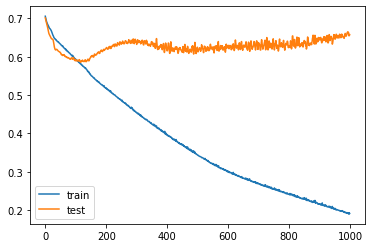

In [143]:
# Criar a rede GRU

# design network
model = Sequential()
model.add(GRU(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Rede MLP

In [184]:
# Extrai os parâmetros necessários de uma segunda forma

# Adendo: Basicamente será testada a rede de Hudgins, mas diferente do artigo original será usada uma rede melhorada da RNN,
# que neste caso é a LSTM

# Criação do Array para LSTM
segments = 1 # Assim como Hudgins é possível modificar a quantidade de segmentos e ver o quanto melhora ou piora a acurácia obtida

X = np.ones((len(Part_normalize), 6))

# Extrair características
for idx,p in enumerate(Part_normalize):
    X[idx,0] = mean_absolute_value(p, segments)[0]
    X[idx,1] = waveform_length(p, segments)[0]
    X[idx,2] = f_rms(p, segments)[0]
    X[idx,3] = mean_absolute_value_slope(p, segments)[0]
    X[idx,4] = zero_crossing(p, segments)[0]
    X[idx,5] = slope_sign_changes(p, segments)[0]

# Reshape deve ser: (quantidade de amostras, 3)
y = np.array(y)

display(X[0,:])
display(X[2,:])
display(X.shape)

array([  0.3258577 ,  51.93235632,   0.40182367,   0.        ,
        35.        , 129.        ])

array([  0.30053767,  50.98216874,   0.37882158,   0.        ,
        45.        , 134.        ])

(80, 6)

In [185]:
# Importando biblioteca de treino e teste
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

display(X_train)
display(y_train)
display(X_test)
display(y_test)

array([[  0.25169316,  50.9475372 ,   0.31692257,   0.        ,
         44.        , 185.        ],
       [  0.42058172,  52.96967592,   0.51453239,   0.        ,
         34.        , 146.        ],
       [  0.3034468 ,  51.17446747,   0.38956685,   0.        ,
         38.        , 179.        ],
       [  0.35316232,  55.28883356,   0.44412305,   0.        ,
         42.        , 141.        ],
       [  0.2559587 ,  48.06429809,   0.31868722,   0.        ,
         49.        , 187.        ],
       [  0.3258577 ,  51.93235632,   0.40182367,   0.        ,
         35.        , 129.        ],
       [  0.32561922,  46.90188169,   0.41168989,   0.        ,
         35.        , 133.        ],
       [  0.33067076,  48.32273901,   0.41243904,   0.        ,
         39.        , 129.        ],
       [  0.40549753,  62.10486254,   0.49514893,   0.        ,
         45.        , 129.        ],
       [  0.28006639,  47.09824011,   0.36683254,   0.        ,
         46.        , 166. 

array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0]])

array([[  0.33999448,  52.60971382,   0.42561573,   0.        ,
         41.        , 160.        ],
       [  0.27113855,  43.79372303,   0.34744302,   0.        ,
         34.        , 145.        ],
       [  0.27561654,  52.11615478,   0.35217233,   0.        ,
         41.        , 139.        ],
       [  0.28453902,  45.61099769,   0.34706218,   0.        ,
         33.        , 167.        ],
       [  0.33159419,  55.14861389,   0.4237996 ,   0.        ,
         34.        , 105.        ],
       [  0.2659262 ,  47.11251426,   0.32286311,   0.        ,
         36.        , 148.        ],
       [  0.40610175,  56.7389379 ,   0.49737194,   0.        ,
         48.        , 124.        ],
       [  0.31007784,  49.49582159,   0.40867383,   0.        ,
         49.        , 139.        ],
       [  0.32237048,  48.39472321,   0.40722679,   0.        ,
         35.        , 148.        ],
       [  0.29811187,  53.06852354,   0.36604684,   0.        ,
         33.        , 144. 

array([[1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [196]:
# Importar bibliotecas para criação do modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input

# Criar rede MLP

model = Sequential()
model.add(Input(shape=(6,)))
model.add(Dense(2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

#model.get_config()

#model.get_weights()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 2)                 14        
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 3         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [197]:
# Definindo método de acurácia e perda
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Train on 64 samples, validate on 16 samples
Epoch 1/1000
64/64 - 3s - loss: 22.1806 - acc: 0.5000 - val_loss: 21.9628 - val_acc: 0.5000
Epoch 2/1000
64/64 - 0s - loss: 22.0354 - acc: 0.5000 - val_loss: 21.8186 - val_acc: 0.5000
Epoch 3/1000
64/64 - 0s - loss: 21.8906 - acc: 0.5000 - val_loss: 21.6750 - val_acc: 0.5000
Epoch 4/1000
64/64 - 0s - loss: 21.7464 - acc: 0.5000 - val_loss: 21.5318 - val_acc: 0.5000
Epoch 5/1000
64/64 - 0s - loss: 21.6027 - acc: 0.5000 - val_loss: 21.3892 - val_acc: 0.5000
Epoch 6/1000
64/64 - 0s - loss: 21.4595 - acc: 0.5000 - val_loss: 21.2471 - val_acc: 0.5000
Epoch 7/1000
64/64 - 0s - loss: 21.3168 - acc: 0.5000 - val_loss: 21.1055 - val_acc: 0.5000
Epoch 8/1000
64/64 - 0s - loss: 21.1746 - acc: 0.5000 - val_loss: 20.9644 - val_acc: 0.5000
Epoch 9/1000
64/64 - 0s - loss: 21.0330 - acc: 0.5000 - val_loss: 20.8239 - val_acc: 0.5000
Epoch 10/1000
64/64 - 0s - loss: 20.8919 - acc: 0.5000 - val_loss: 20.6840 - val_acc: 0.5000
Epoch 11/1000
64/64 - 0s - loss: 20

Epoch 89/1000
64/64 - 0s - loss: 11.6874 - acc: 0.5000 - val_loss: 11.5628 - val_acc: 0.5000
Epoch 90/1000
64/64 - 0s - loss: 11.5950 - acc: 0.5000 - val_loss: 11.4713 - val_acc: 0.5000
Epoch 91/1000
64/64 - 0s - loss: 11.5032 - acc: 0.5000 - val_loss: 11.3803 - val_acc: 0.5000
Epoch 92/1000
64/64 - 0s - loss: 11.4119 - acc: 0.5000 - val_loss: 11.2899 - val_acc: 0.5000
Epoch 93/1000
64/64 - 0s - loss: 11.3211 - acc: 0.5000 - val_loss: 11.2000 - val_acc: 0.5000
Epoch 94/1000
64/64 - 0s - loss: 11.2309 - acc: 0.5000 - val_loss: 11.1107 - val_acc: 0.5000
Epoch 95/1000
64/64 - 0s - loss: 11.1413 - acc: 0.5000 - val_loss: 11.0218 - val_acc: 0.5000
Epoch 96/1000
64/64 - 0s - loss: 11.0522 - acc: 0.5000 - val_loss: 10.9336 - val_acc: 0.5000
Epoch 97/1000
64/64 - 0s - loss: 10.9636 - acc: 0.5000 - val_loss: 10.8459 - val_acc: 0.5000
Epoch 98/1000
64/64 - 0s - loss: 10.8755 - acc: 0.5000 - val_loss: 10.7587 - val_acc: 0.5000
Epoch 99/1000
64/64 - 0s - loss: 10.7880 - acc: 0.5000 - val_loss: 10.

Epoch 178/1000
64/64 - 0s - loss: 5.3676 - acc: 0.5000 - val_loss: 5.3036 - val_acc: 0.5000
Epoch 179/1000
64/64 - 0s - loss: 5.3154 - acc: 0.5000 - val_loss: 5.2519 - val_acc: 0.5000
Epoch 180/1000
64/64 - 0s - loss: 5.2635 - acc: 0.5000 - val_loss: 5.2005 - val_acc: 0.5000
Epoch 181/1000
64/64 - 0s - loss: 5.2120 - acc: 0.5000 - val_loss: 5.1495 - val_acc: 0.5000
Epoch 182/1000
64/64 - 0s - loss: 5.1608 - acc: 0.5000 - val_loss: 5.0988 - val_acc: 0.5000
Epoch 183/1000
64/64 - 0s - loss: 5.1100 - acc: 0.5000 - val_loss: 5.0484 - val_acc: 0.5000
Epoch 184/1000
64/64 - 0s - loss: 5.0595 - acc: 0.5000 - val_loss: 4.9984 - val_acc: 0.5000
Epoch 185/1000
64/64 - 0s - loss: 5.0094 - acc: 0.5000 - val_loss: 4.9487 - val_acc: 0.5000
Epoch 186/1000
64/64 - 0s - loss: 4.9596 - acc: 0.5000 - val_loss: 4.8994 - val_acc: 0.5000
Epoch 187/1000
64/64 - 0s - loss: 4.9101 - acc: 0.5000 - val_loss: 4.8504 - val_acc: 0.5000
Epoch 188/1000
64/64 - 0s - loss: 4.8610 - acc: 0.5000 - val_loss: 4.8017 - val_

Epoch 268/1000
64/64 - 0s - loss: 1.8328 - acc: 0.5000 - val_loss: 1.8008 - val_acc: 0.5000
Epoch 269/1000
64/64 - 0s - loss: 1.8051 - acc: 0.5000 - val_loss: 1.7733 - val_acc: 0.5000
Epoch 270/1000
64/64 - 0s - loss: 1.7775 - acc: 0.5000 - val_loss: 1.7460 - val_acc: 0.5000
Epoch 271/1000
64/64 - 0s - loss: 1.7503 - acc: 0.5000 - val_loss: 1.7191 - val_acc: 0.5000
Epoch 272/1000
64/64 - 0s - loss: 1.7233 - acc: 0.5000 - val_loss: 1.6923 - val_acc: 0.5000
Epoch 273/1000
64/64 - 0s - loss: 1.6966 - acc: 0.5000 - val_loss: 1.6659 - val_acc: 0.5000
Epoch 274/1000
64/64 - 0s - loss: 1.6701 - acc: 0.5000 - val_loss: 1.6397 - val_acc: 0.5000
Epoch 275/1000
64/64 - 0s - loss: 1.6440 - acc: 0.5000 - val_loss: 1.6138 - val_acc: 0.5000
Epoch 276/1000
64/64 - 0s - loss: 1.6181 - acc: 0.5000 - val_loss: 1.5882 - val_acc: 0.5000
Epoch 277/1000
64/64 - 0s - loss: 1.5925 - acc: 0.5000 - val_loss: 1.5629 - val_acc: 0.5000
Epoch 278/1000
64/64 - 0s - loss: 1.5672 - acc: 0.5000 - val_loss: 1.5378 - val_

Epoch 358/1000
64/64 - 0s - loss: 0.6661 - acc: 0.5781 - val_loss: 0.6361 - val_acc: 0.6875
Epoch 359/1000
64/64 - 0s - loss: 0.6651 - acc: 0.5781 - val_loss: 0.6349 - val_acc: 0.6875
Epoch 360/1000
64/64 - 0s - loss: 0.6642 - acc: 0.5938 - val_loss: 0.6337 - val_acc: 0.6250
Epoch 361/1000
64/64 - 0s - loss: 0.6633 - acc: 0.6094 - val_loss: 0.6326 - val_acc: 0.6250
Epoch 362/1000
64/64 - 0s - loss: 0.6625 - acc: 0.6250 - val_loss: 0.6316 - val_acc: 0.6875
Epoch 363/1000
64/64 - 0s - loss: 0.6618 - acc: 0.6406 - val_loss: 0.6306 - val_acc: 0.6875
Epoch 364/1000
64/64 - 0s - loss: 0.6611 - acc: 0.6562 - val_loss: 0.6297 - val_acc: 0.6875
Epoch 365/1000
64/64 - 0s - loss: 0.6604 - acc: 0.6562 - val_loss: 0.6289 - val_acc: 0.6875
Epoch 366/1000
64/64 - 0s - loss: 0.6598 - acc: 0.6562 - val_loss: 0.6281 - val_acc: 0.6875
Epoch 367/1000
64/64 - 0s - loss: 0.6593 - acc: 0.6562 - val_loss: 0.6273 - val_acc: 0.6875
Epoch 368/1000
64/64 - 0s - loss: 0.6588 - acc: 0.6719 - val_loss: 0.6266 - val_

Epoch 448/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6156 - val_acc: 0.7500
Epoch 449/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6156 - val_acc: 0.7500
Epoch 450/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6156 - val_acc: 0.7500
Epoch 451/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6156 - val_acc: 0.7500
Epoch 452/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6156 - val_acc: 0.7500
Epoch 453/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6156 - val_acc: 0.7500
Epoch 454/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6156 - val_acc: 0.7500
Epoch 455/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6156 - val_acc: 0.7500
Epoch 456/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6156 - val_acc: 0.7500
Epoch 457/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6155 - val_acc: 0.7500
Epoch 458/1000
64/64 - 0s - loss: 0.6530 - acc: 0.6875 - val_loss: 0.6155 - val_

Epoch 538/1000
64/64 - 0s - loss: 0.6529 - acc: 0.6875 - val_loss: 0.6150 - val_acc: 0.7500
Epoch 539/1000
64/64 - 0s - loss: 0.6529 - acc: 0.6875 - val_loss: 0.6150 - val_acc: 0.7500
Epoch 540/1000
64/64 - 0s - loss: 0.6529 - acc: 0.6875 - val_loss: 0.6150 - val_acc: 0.7500
Epoch 541/1000
64/64 - 0s - loss: 0.6529 - acc: 0.6875 - val_loss: 0.6150 - val_acc: 0.7500
Epoch 542/1000
64/64 - 0s - loss: 0.6529 - acc: 0.6875 - val_loss: 0.6150 - val_acc: 0.7500
Epoch 543/1000
64/64 - 0s - loss: 0.6529 - acc: 0.6875 - val_loss: 0.6150 - val_acc: 0.7500
Epoch 544/1000
64/64 - 0s - loss: 0.6529 - acc: 0.6875 - val_loss: 0.6150 - val_acc: 0.7500
Epoch 545/1000
64/64 - 0s - loss: 0.6529 - acc: 0.6875 - val_loss: 0.6150 - val_acc: 0.7500
Epoch 546/1000
64/64 - 0s - loss: 0.6529 - acc: 0.6875 - val_loss: 0.6150 - val_acc: 0.7500
Epoch 547/1000
64/64 - 0s - loss: 0.6529 - acc: 0.6875 - val_loss: 0.6150 - val_acc: 0.7500
Epoch 548/1000
64/64 - 0s - loss: 0.6528 - acc: 0.6875 - val_loss: 0.6150 - val_

Epoch 628/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6145 - val_acc: 0.7500
Epoch 629/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6145 - val_acc: 0.7500
Epoch 630/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6144 - val_acc: 0.7500
Epoch 631/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6144 - val_acc: 0.7500
Epoch 632/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6144 - val_acc: 0.7500
Epoch 633/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6144 - val_acc: 0.7500
Epoch 634/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6144 - val_acc: 0.7500
Epoch 635/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6144 - val_acc: 0.7500
Epoch 636/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6144 - val_acc: 0.7500
Epoch 637/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6144 - val_acc: 0.7500
Epoch 638/1000
64/64 - 0s - loss: 0.6527 - acc: 0.6875 - val_loss: 0.6144 - val_

Epoch 718/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6139 - val_acc: 0.7500
Epoch 719/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6139 - val_acc: 0.7500
Epoch 720/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6138 - val_acc: 0.7500
Epoch 721/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6138 - val_acc: 0.7500
Epoch 722/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6138 - val_acc: 0.7500
Epoch 723/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6138 - val_acc: 0.7500
Epoch 724/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6138 - val_acc: 0.7500
Epoch 725/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6138 - val_acc: 0.7500
Epoch 726/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6138 - val_acc: 0.7500
Epoch 727/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6138 - val_acc: 0.7500
Epoch 728/1000
64/64 - 0s - loss: 0.6526 - acc: 0.6875 - val_loss: 0.6138 - val_

64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6133 - val_acc: 0.7500
Epoch 808/1000
64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6133 - val_acc: 0.7500
Epoch 809/1000
64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6132 - val_acc: 0.7500
Epoch 810/1000
64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6132 - val_acc: 0.7500
Epoch 811/1000
64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6132 - val_acc: 0.7500
Epoch 812/1000
64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6132 - val_acc: 0.7500
Epoch 813/1000
64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6132 - val_acc: 0.7500
Epoch 814/1000
64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6132 - val_acc: 0.7500
Epoch 815/1000
64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6132 - val_acc: 0.7500
Epoch 816/1000
64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6132 - val_acc: 0.7500
Epoch 817/1000
64/64 - 0s - loss: 0.6525 - acc: 0.6875 - val_loss: 0.6132 - val_acc: 0.7500
Epo

Epoch 897/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_acc: 0.7500
Epoch 898/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_acc: 0.7500
Epoch 899/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_acc: 0.7500
Epoch 900/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_acc: 0.7500
Epoch 901/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_acc: 0.7500
Epoch 902/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_acc: 0.7500
Epoch 903/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_acc: 0.7500
Epoch 904/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_acc: 0.7500
Epoch 905/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_acc: 0.7500
Epoch 906/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_acc: 0.7500
Epoch 907/1000
64/64 - 0s - loss: 0.6524 - acc: 0.6875 - val_loss: 0.6126 - val_

Epoch 987/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 988/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 989/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 990/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 991/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 992/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 993/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 994/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 995/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 996/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_acc: 0.7500
Epoch 997/1000
64/64 - 0s - loss: 0.6523 - acc: 0.6875 - val_loss: 0.6120 - val_

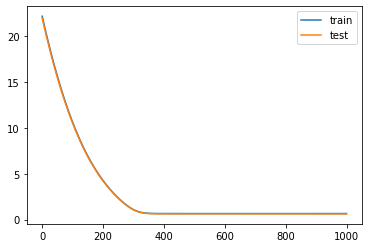

In [198]:
#Gerando o modelo fit

history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [192]:
# Verificar acurácia e perda